<a href="https://colab.research.google.com/github/florentPoux/point-cloud-processing/blob/main/3D_Point_cloud_automatic_segmentation_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Florent Poux, 2021. Licence MIT

*   To reuse in your project, please cite the article accessible here: 
[To Medium Article](https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c)
*   Have fun with this notebook that you can very simply run (ctrl+Enter) !
*   The first time thought, it will ask you to get a key for it to be able to acces your Google drive folders if you want to work all remotely.
*   Simply accept, and then change the input path by the folder path containing your data, on Google Drive.

Enjoy!

# Step 1 & 2: Setting up the environment and loading the data

In [ ]:
#This code snippet allows to use data directly from your Google drives files.
#If you want to use a shared folder, just add the folder to your drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# http://www.open3d.org/docs/release/getting_started.html
!pip install open3d

#libraries used
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

In [ ]:
#create paths and load data
input_path="gdrive/My Drive/_MEDIUM/DATA/Point Cloud Sample/"
dataname="TLS_kitchen.ply"

pcd = o3d.io.read_point_cloud(input_path+dataname)

# Step 3: First segmentation round

## 3.1 [Optional] Normals computation

In [ ]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
pcd.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd]) #Works only outside Jupyter/Colab

## 3.2 [INITIATION] 3D Shape Detection with RANSAC

In [ ]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])
# o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

## 3.3 [INITIATION] Clustering with DBSCAN

In [ ]:
labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=10))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# o3d.visualization.draw_geometries([pcd])

# Step 4: Scaling and automation

## 4.1 RANSAC loop for multiple planar shapes detection

In [ ]:
segment_models={}
segments={}
max_plane_idx=10
rest=pcd
for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
    segments[i]=rest.select_by_index(inliers)
    segments[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers, invert=True)
    print("pass",i,"/",max_plane_idx,"done.")

#o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])

## 4.2 Refined RANSAC with Euclidean clustering

In [ ]:
segment_models={}
segments={}
max_plane_idx=20
rest=pcd
d_threshold=0.01
for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
    segments[i]=rest.select_by_index(inliers)
    labels = np.array(segments[i].cluster_dbscan(eps=d_threshold*10, min_points=10))
    candidates=[len(np.where(labels==j)[0]) for j in np.unique(labels)]
    best_candidate=int(np.unique(labels)[np.where(candidates==np.max(candidates))[0]])
    print("the best candidate is: ", best_candidate)
    rest = rest.select_by_index(inliers, invert=True)+segments[i].select_by_index(list(np.where(labels!=best_candidate)[0]))
    segments[i]=segments[i].select_by_index(list(np.where(labels==best_candidate)[0]))
    segments[i].paint_uniform_color(list(colors[:3]))
    print("pass",i+1,"/",max_plane_idx,"done.")

## 4.3 Euclidean clustering of the rest with DBSCAN

In [ ]:
labels = np.array(rest.cluster_dbscan(eps=0.05, min_points=5))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab10")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
rest.colors = o3d.utility.Vector3dVector(colors[:, :3])

# o3d.visualization.draw_geometries([segments.values()])
# o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest],
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest],zoom=0.3199,front=[0.30159062875123849, 0.94077325609922868, 0.15488309545553303],lookat=[-3.9559999108314514, -0.055000066757202148, -0.27599999308586121],up=[-0.044411423633999815, -0.138726419067636, 0.98753122516983349])
# o3d.visualization.draw_geometries([rest])

# BONUS: Small drawing function for Colab

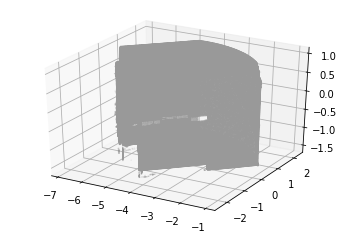

In [ ]:
from mpl_toolkits import mplot3d

pc=np.asarray(pcd.points)
ax = plt.axes(projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c = np.asarray(pcd.colors), s=0.01)
plt.show()